In [48]:
import os
os.chdir("/home/imendoza/deblend/galaxy-net")
import sys
sys.path.insert(0, "/home/imendoza/deblend/galaxy-net")
sys.path.insert(0, "/home/imendoza/deblend/galaxy-net/WeakLensingDeblending")
sys.path.insert(0, "/home/imendoza/deblend/galaxy-net/BlendingToolKit")

import numpy as np
import btk
import btk.config, btk.plot_utils

print(os.getcwd())

/home/imendoza/deblend/galaxy-net


In [18]:
def new_center_shift(Args, number_of_objects):
    """Shift galaxy centers with a value drawn from a normal distribution with
    mean 0 and std 1 arcseconds."""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """Returns catalog with parametrs to draw one blend scene.
    
    Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift().
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Determine number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 25.3) & (np.abs(catalog['i_ab'] - catalog['r_ab']) > 0.5))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [49]:
catalog_name = os.path.join(os.getcwd(), 'params', 'OneDegSq.fits')
print(catalog_name)

# Load parameters
param = btk.config.Simulation_params(catalog_name, max_number=1, batch_size=1)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

/home/imendoza/deblend/galaxy-net/params/OneDegSq.fits


astropy.table.table.Table

In [69]:
catalog.columns.keys()

['galtileid',
 'ra',
 'dec',
 'redshift',
 'fluxnorm_bulge',
 'fluxnorm_disk',
 'fluxnorm_agn',
 'a_b',
 'a_d',
 'b_b',
 'b_d',
 'pa_bulge',
 'pa_disk',
 'u_ab',
 'g_ab',
 'r_ab',
 'i_ab',
 'z_ab',
 'y_ab']

In [23]:
#Generate catalogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator)


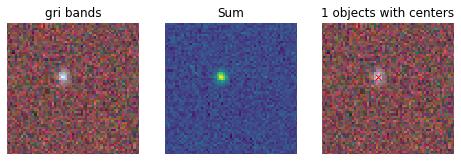

CPU times: user 2.16 s, sys: 75.9 ms, total: 2.23 s
Wall time: 329 ms


In [47]:
%%time
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90),band_indices=[1,2,3])

In [41]:
blend_images.shape

(1, 120, 120, 6)